#### Prerequesites:
* Define schema (make figure) 
* Define structure (make figure)
* Define schema class in python (src/models/model_schemata.py)
* Convert schema + structure into model template (models/templates/p_model.pl)

#### Procedure:
* Load data
* Create lfi script
* Add uncertain evidence to lfi model as probabilistic clauses

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importing libraries
import pandas as pd
import os

from src.models import model_schemata as schema
from src.models import build_model as build
from src.data import prep_data as prep

In [3]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

In [4]:
es_interaction = pd.read_csv('data/processed/ebdt_data/es_interaction_tp.csv')
e_function = pd.read_csv('data/processed/ebdt_data/e_function.csv')
p_fc = pd.read_csv('data/processed/ebdt_data/p_fc_scaled_HL60_tp.csv')
e_ksea = pd.read_csv('data/processed/ebdt_data/e_ksea_penalised_HL60.csv')

In [5]:
# Filtering
# remove interactions where the kpa is not in the phosphoproteomics data
es_interaction = es_interaction[es_interaction['substrate'].isin(p_fc['phosphosite'])]
es_interaction = es_interaction[es_interaction['enzyme'].isin(e_ksea['enzyme'])]
# select fold change data for psts which are in interaction data
p_fc = p_fc[p_fc['phosphosite'].isin(es_interaction['substrate'])]
e_ksea = e_ksea[e_ksea['enzyme'].isin(es_interaction['enzyme'])]
# select enzyme function data for enzymes which are in interaction data
e_function = e_function[e_function['enzyme'].isin(es_interaction['enzyme'])]
# define all pst which are in fold change data or interaction data and store in data frame
phosphosites = list(set(p_fc['phosphosite'].tolist()))
# define all enzymes which are in activity, interaction or enz_class data and store in data frame
enzymes = list(set(es_interaction['enzyme'].tolist()))

In [6]:
es_interaction

,enzyme,substrate
0,ABL1,ABI1(Y213)
15,ABL1,CDK5(Y15)
18,ABL1,CRKL(Y207)
22,ABL1,DGCR8(Y267)
50,ABL1,PIK3AP1(Y570)
...,...,...
10328,WEE1,CDK1(Y15)
10330,WEE1,CDK2(Y15)
10332,WEE1,WEE1(T173)
10337,WNK1,STK39(S371)


<Axes: ylabel='Frequency'>

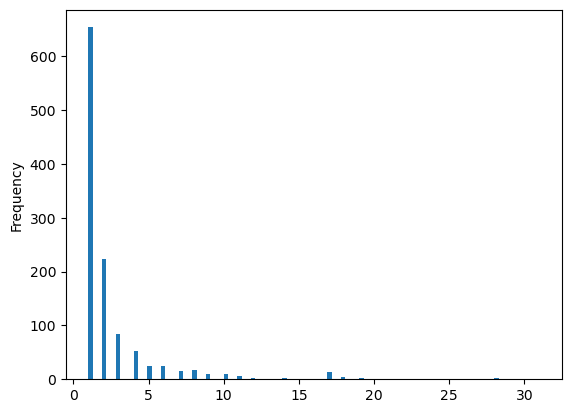

In [7]:
# plot histogram of number of interactions per phosphosite
es_interaction['substrate'].value_counts().plot(kind='hist', bins=100)

In [8]:
# Create pandas DataFrames
interactions = es_interaction.loc[es_interaction['substrate'].isin(es_interaction['substrate'].value_counts()[es_interaction['substrate'].value_counts() >= 7].index)].reset_index(drop=True)
subs = p_fc.loc[p_fc['phosphosite'].isin(interactions['substrate'])].reset_index(drop=True)
enz = e_ksea.loc[e_ksea['enzyme'].isin(interactions['enzyme'])].reset_index(drop=True)

substrate_correlations, sorted_enzyme_correlations = prep.extract_top_corr_enzymes(subs, enz, interactions, max_enzymes=7, min_corr=0)

# Filter the interactions based on substrate_correlations
filtered_interactions = prep.filter_interactions_by_correlations(es_interaction, substrate_correlations)

<Axes: ylabel='Frequency'>

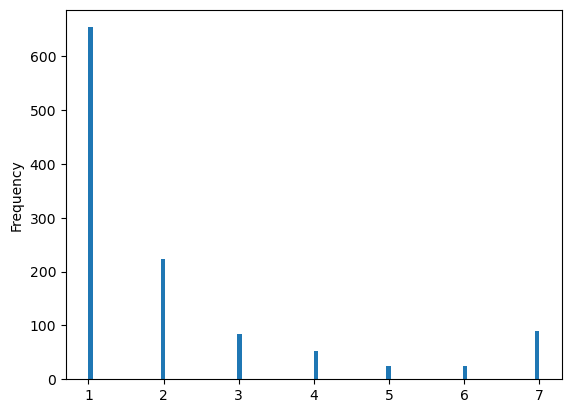

In [9]:
filtered_interactions.substrate.value_counts().plot(kind='hist', bins=100)

In [14]:
e_ksea = e_ksea[e_ksea['enzyme'].isin(filtered_interactions['enzyme'])]
e_function = e_function[e_function['enzyme'].isin(filtered_interactions['enzyme'])]

In [11]:
# Mapping data to Problog predicates
predicates = {}
predicates['enzyme'] = schema.EnzymePredicate(enzyme_list=enzymes)
predicates['phosphosite'] = schema.PhosphositePredicate(phosphosite_list=phosphosites)
predicates['es_interaction'] = schema.ESInteractionPredicate(dataframe=filtered_interactions, enzyme_col='enzyme', phosphosite_col='substrate')
predicates['e_function'] = schema.EFunctionPredicate(dataframe=e_function, enzyme_col='enzyme', function_col='function')

# Adding entites, relationships, and fixed attributes to template model
model_skeleton = 'models/ebdt_data/p_model/p_model_lfi_run1.pl'

for predicate in predicates:
    fact_generator = build.ProblogStatementGenerator(predicates[predicate])
    problog_facts = fact_generator.generate_facts(build.FactTemplate) # generate Problog facts
    build.insert_statements(model=model_skeleton, statements=problog_facts, location='%% {}'.format(predicate)) # insert into Problog file

In [15]:
e_ksea_ad = prep.expand_ad_cpd(e_ksea, 'value')
p_fc_ad = prep.expand_ad_cpd(p_fc, 'value')
p_fc_ad

,phosphosite,sample,value,prob,p_dec,p_inc,p_base
0,AAK1(T389),AC220,dec,0.932900,0.932900,0.001000,0.066100
1,AAK1(T389),AC220,inc,0.932900,0.001000,0.932900,0.066100
2,AAK1(T389),AT13148,dec,0.009176,0.009176,0.001000,0.989824
3,AAK1(T389),AT13148,inc,0.009176,0.001000,0.009176,0.989824
4,AAK1(T389),AZ20,dec,0.456921,0.456921,0.001000,0.542079
...,...,...,...,...,...,...,...
140661,ZYX(S308),U73122,inc,0.083518,0.001000,0.083518,0.915482
140662,ZYX(S308),Ulixertinib,dec,0.820205,0.820205,0.001000,0.178795
140663,ZYX(S308),Ulixertinib,inc,0.820205,0.001000,0.820205,0.178795
140664,ZYX(S308),Vemurafenib,dec,0.549124,0.549124,0.001000,0.449876


In [13]:
# Mapping data to Problog predicates
# make sure to delete 'base' from schemata and AnnotatedDisjunctionClauseTemplate
predicates = {}
predicates['e_ksea'] = schema.EKseaPredicate()
predicates['e_ksea'].add_data(e_ksea_ad, 'enzyme', 'sample', 'value')
predicates['e_ksea'].add_ad_probabilities(e_ksea_ad, p_dec_col='p_dec', p_base_col='p_base', p_inc_col='p_inc')
predicates['p_fc'] = schema.PFoldChangePredicate()
predicates['p_fc'].add_data(p_fc_ad, 'phosphosite', 'sample', 'value')
predicates['p_fc'].add_ad_probabilities(p_fc_ad, p_dec_col='p_dec', p_base_col='p_base', p_inc_col='p_inc')

In [14]:
model_lfi = 'models/ebdt_data/p_model/p_model_lfi_run1.pl'
for predicate in predicates: 
    ad_generator = build.ProblogStatementGenerator(predicates[predicate])
    clauses = ad_generator.generate_ad_clauses(type='boolean')
    clauses.extend(ad_generator.generate_ad_clauses(type='domain'))
    build.insert_statements(model=model_lfi, statements=clauses, location='%% p1::{}'.format(predicate)) # insert into Problog file

In [16]:
es_interaction.to_csv('data/processed/ebdt_data/run1/es_interaction.csv', index=False)
filtered_interactions.to_csv('data/processed/ebdt_data/run1/es_interaction_top7enz.csv', index=False)
p_fc.to_csv('data/processed/ebdt_data/run1/p_fc.csv', index=False)
e_ksea.to_csv('data/processed/ebdt_data/run1/e_ksea.csv', index=False)
e_function.to_csv('data/processed/ebdt_data/run1/e_function.csv', index=False)

In [31]:
filtered_interactions['enzyme'].value_counts() < 6

CDK2       False
CDK1       False
MAPK1      False
PRKACA     False
CSNK2A1    False
           ...  
PTPRF       True
TNK2        True
PTPN2       True
ERBB2       True
WNK2        True
Name: enzyme, Length: 273, dtype: bool